In [1]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/LEVEL 1/torch')
from multiclass_functions2 import * # my module import
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

Mounted at /content/drive
cuda


In [ ]:
BATCH_SIZE = 64
LR = 2e-3
LR_STEP = 3
LR_GAMMA = 0.9
LAMBDA = 1e-6
EPOCH = 15
criterion = nn.CrossEntropyLoss()
new_model_train = False
model_type = "CNN_deep"
dataset = "STL10"
save_model_path = f'/content/drive/MyDrive/Colab Notebooks/results/{model_type}_{dataset}.pt'
save_history_path = f'/content/drive/MyDrive/Colab Notebooks/results/{model_type}_history_{dataset}.pt'

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomAffine(degrees=(0,10),translate=(0.1,0.2),scale=(0.5,1.2)),
    transforms.ToTensor()])

transform_test = transforms.Compose([
    transforms.ToTensor()])

In [ ]:
class SubsetWithTransform(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        self.classes = subset.dataset.classes

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        x, y = self.subset[idx]
        if self.transform:
            x = self.transform(x)
        return x, y

In [ ]:
train_DS = datasets.STL10(root = '/content/drive/MyDrive/Colab Notebooks/data', split="train", download=True)
NoT = int(0.8 * len(train_DS))
NoV = len(train_DS) - NoT
train_DS, val_DS = random_split(train_DS, [NoT, NoV])

train_DS = SubsetWithTransform(train_DS, transform=transform_train) # transform을 train과 val 다르게 주기 위함
val_DS = SubsetWithTransform(val_DS, transform=transform_test) # transform을 train과 val 다르게 주기 위함
test_DS = datasets.STL10(root = '/content/drive/MyDrive/Colab Notebooks/data', split="test", download=True, transform=transform_test)

train_DL = DataLoader(train_DS, batch_size = BATCH_SIZE, shuffle = True)
val_DL = DataLoader(val_DS, batch_size = BATCH_SIZE, shuffle = True)
test_DL = DataLoader(test_DS, batch_size = BATCH_SIZE, shuffle = True)

In [ ]:
print(len(train_DS))
print(len(val_DS))
print(len(test_DS))

4000
1000
8000


['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']
torch.Size([64, 3, 96, 96])
deer


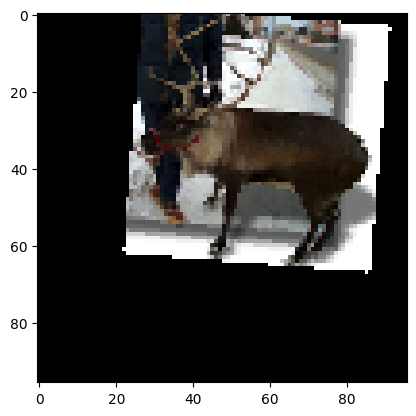

In [ ]:
print(test_DS.classes)
x_batch, y_batch = next(iter(train_DL))
print(x_batch.shape)
plt.imshow(x_batch[0].permute(1,2,0))
print(test_DS.classes[y_batch[0]])

torch.Size([64, 3, 96, 96])
cat


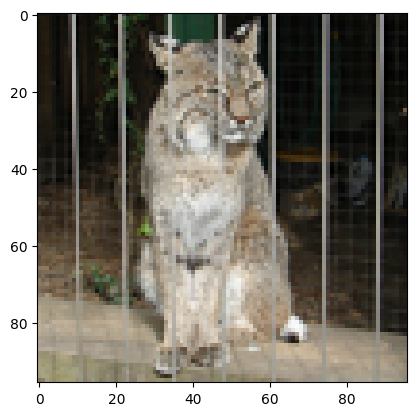

In [ ]:
x_batch, y_batch = next(iter(val_DL))
print(x_batch.shape)
plt.imshow(x_batch[0].permute(1,2,0))
print(test_DS.classes[y_batch[0]])

torch.Size([64, 3, 96, 96])
bird


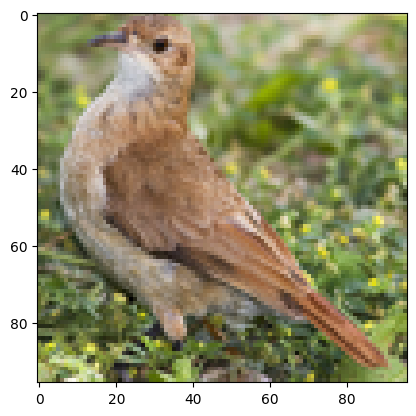

In [ ]:
x_batch, y_batch = next(iter(test_DL))
print(x_batch.shape)
plt.imshow(x_batch[0].permute(1,2,0))
print(test_DS.classes[y_batch[0]])

In [ ]:
class CNN_deep(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_block1 = nn.Sequential(nn.Conv2d(3,32,3,padding=1, bias=False),
                                         nn.BatchNorm2d(32),
                                         nn.ReLU(),
                                         nn.Conv2d(32,32,3,padding=1, bias=False),
                                         nn.BatchNorm2d(32),
                                         nn.ReLU())
        self.Maxpool1 = nn.MaxPool2d(2)
        self.conv_block2 = nn.Sequential(nn.Conv2d(32,64,3,padding=1, bias=False),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU(),
                                         nn.Conv2d(64,64,3,padding=1, bias=False),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU(),
                                         nn.Conv2d(64,64,3,padding=1, bias=False),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU())
        self.Maxpool2 = nn.MaxPool2d(2)

        self.conv_block3 = nn.Sequential(nn.Conv2d(64,128,3,padding=1, bias=False),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU(),
                                         nn.Conv2d(128,128,3,padding=1, bias=False),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU(),
                                         nn.Conv2d(128,128,3,padding=1, bias=False),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU())
        self.Maxpool3 = nn.MaxPool2d(2)
        self.classifier = nn.Sequential(nn.Linear(128*12*12,512),
                                        nn.ReLU(),
                                        nn.Linear(512,10))

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.Maxpool1(x)
        x = self.conv_block2(x)
        x = self.Maxpool2(x)
        x = self.conv_block3(x)
        x = self.Maxpool3(x)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        return x

In [ ]:
model = globals()[model_type]().to(DEVICE)
print(model)

x_batch, _ = next(iter(train_DL))
print(x_batch.shape)

model.eval()
with torch.no_grad():
    print(model(x_batch.to(DEVICE)).shape)

CNN_deep(
  (conv_block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (Maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

In [ ]:
if new_model_train:
    params = [p for p in model.parameters() if p.requires_grad] # for transfer learning
    optimizer = optim.Adam(params, lr = LR, weight_decay=LAMBDA)
    scheduler = StepLR(optimizer, step_size=LR_STEP, gamma=LR_GAMMA)

    Train(model, train_DL, val_DL, criterion, optimizer, scheduler,
          EPOCH, BATCH_SIZE, save_model_path, save_history_path)

Epoch: 1, current_LR = 0.002


train loss: 5.32023, val loss: 2.33069 
train acc: 11.2 %, val acc: 9.2 %, time: 410 s
--------------------
Epoch: 2, current_LR = 0.002


train loss: 2.30384, val loss: 2.25753 
train acc: 11.9 %, val acc: 15.4 %, time: 413 s
--------------------
Epoch: 3, current_LR = 0.002


KeyboardInterrupt: 

In [ ]:
loaded = torch.load(save_model_path, map_location=DEVICE, weights_only=False)
load_model = loaded["model"]
ep = loaded["ep"]
optimizer = loaded["optimizer"]
scheduler = loaded["scheduler"]

loaded = torch.load(save_history_path, map_location=DEVICE, weights_only=False)
loss_history = loaded["loss_history"]
acc_history = loaded["acc_history"]

print(ep)
print(optimizer)
print(scheduler.step_size)
print(scheduler.gamma)

In [ ]:
plt.figure()
plt.plot(range(1,EPOCH+1), loss_history["train"], label="train")
plt.plot(range(1,EPOCH+1), loss_history["val"], label="val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train, Val Loss")
plt.legend()
plt.grid()

plt.figure()
plt.plot(range(1,EPOCH+1), acc_history["train"], label="train")
plt.plot(range(1,EPOCH+1), acc_history["val"], label="val")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train, Val Accuracy")
plt.legend()
plt.grid()

In [ ]:
Test(load_model, test_DL, criterion)
print(count_params(load_model))

In [ ]:
Test_plot(load_model,test_DL)

In [ ]:
confusion = get_conf(load_model, test_DL)
plot_confusion_matrix(confusion, test_DS.classes)
plt.xticks(rotation=45);